In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import transforms
from PIL import Image
convert_tensor = transforms.ToTensor()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
images = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        if filename.find(".jpg") != -1:
            if random.random() > 0.5:
                images.append(convert_tensor(Image.open(dirname + "/" + filename)))
images = torch.stack(images)
print(images.shape)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

torch.Size([3697, 3, 256, 256])


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
images = images.view(images.shape[0], -1).to(device)

In [4]:
import torch.nn as nn

In [5]:
class GAN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.picasso = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(out_size, 1),
            nn.Sigmoid()
        )
    def forward(self, ins):
        return self.picasso(ins)
    def gan_forward(self, ins):
        return self.critic(ins)
    def __call__(self, ins):
        return self.forward(ins)

In [6]:
net = GAN(10, 200, 3 * 256 * 256).to(device)

In [7]:
net.gan_forward(net(torch.randn(10).to(device)))

tensor([0.4366], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [8]:
num_epochs = 2
batch_size = 2
train_len = len(images)
num_steps = (train_len//batch_size) * num_epochs
lr = 0.0001
optimG = torch.optim.AdamW(net.picasso.parameters(), lr=lr)
optimD = torch.optim.SGD(net.critic.parameters(), lr=lr)

In [9]:
for step in range(num_steps):
    d_batch_real = images[torch.randint(1, train_len-1, (batch_size//2,))]
    d_batch_gen = net(torch.randn(batch_size//2, 10).to(device))
    d_batch = torch.cat((d_batch_real, d_batch_gen)).to(device)
    d_ys = torch.cat((torch.zeros(batch_size//2, 1), torch.ones(batch_size//2, 1))).to(device)
    d_out = net.gan_forward(d_batch)
    
    d_loss = nn.functional.binary_cross_entropy(d_out, d_ys)
    optimD.zero_grad()
    d_loss.backward()
    optimD.step()
    
    
    g_batch = torch.randn(batch_size, 10).to(device)
    g_out = net(g_batch)
    
    g_loss = net.gan_forward(g_out).sum() / len(g_out)
    optimG.zero_grad()
    g_loss.backward()
    optimG.step()
    
    if step % 100 == 0:
        print("Step", str(step) + ", loss D:", str(d_loss.item()) + ", loss G:", g_loss.item())

Step 0, loss D: 0.7684849500656128, loss G: 0.6277356147766113
Step 100, loss D: 5.133491516113281, loss G: 0.043539777398109436
Step 200, loss D: 3.303422689437866, loss G: 0.7122372388839722
Step 300, loss D: 3.276040554046631, loss G: 0.2768724858760834
Step 400, loss D: 50.11585235595703, loss G: 0.8171696066856384
Step 500, loss D: 0.04943885654211044, loss G: 0.5819427967071533
Step 600, loss D: 1.4699903726577759, loss G: 0.024303030222654343
Step 700, loss D: 0.6048381328582764, loss G: 0.7658002972602844
Step 800, loss D: 1.6568773984909058, loss G: 0.3031896650791168
Step 900, loss D: 0.8254207968711853, loss G: 0.6197618842124939
Step 1000, loss D: 0.8628396987915039, loss G: 0.29040801525115967
Step 1100, loss D: 0.8062198758125305, loss G: 0.910362958908081
Step 1200, loss D: 0.8401318788528442, loss G: 0.4796339273452759
Step 1300, loss D: 0.5208052396774292, loss G: 0.5246469378471375
Step 1400, loss D: 0.8487949371337891, loss G: 0.7893873453140259
Step 1500, loss D: 0.

In [10]:
import torchvision

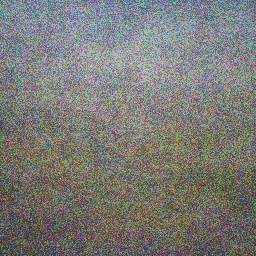

In [11]:
with torch.no_grad():
    ins = torch.randn(10).to(device)
    net_out = net(ins).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(net_out)
    display(image)

In [12]:
#import zipfile
#from PIL import Image

# Create a ZipFile object
#with zipfile.ZipFile('images.zip', 'w') as zip_file:
    # Iterate over the PIL images
#    for x in range(8000):
#        seed = torch.randn(10).to(device)
#        out = net(seed).view(3, 256, 256)
#        image = torchvision.transforms.functional.to_pil_image(out)
#        # Write the image to the zip file
#        zip_file.writestr("image_" + str(x) + ".jpg", image.tobytes())

# Close the ZipFile object
#zip_file.close()

In [13]:
! mkdir ../images

for i in range(8000):
    seed = torch.randn(10).to(device)
    out = net(seed).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(out)
    image.save("../images/" + str(i) + ".jpg")
    i += 1
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'